# Evaluation of multiple datasets

Train and evaluate the two-layered LSTM on all four datasets.



1.   Weizen
2.   Pfeffer
3.   Kugeln
4.   Zylinder




In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

!pip -q install -r ../requirements.txt

TensorFlow 2.x selected.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as K

# custom modules
import data
import model

In [0]:
def train_model(model_name):

  num_time_steps = 40
  nan_value = 0
  batch_size = 64

  csv_data_set = data.CsvDataSet('{}/trackSortResult{}/*_trackHistory_NothingDeleted.csv'.format(model_name, model_name),
                                timesteps=num_time_steps, nan_value=nan_value, batch_size=batch_size)
  
  dataset_train, dataset_test = csv_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

  csv_data_set.plot_random_tracks(n=15)

  rnn_model, hash_ = model.rnn_model_factory(
          num_units_first_rnn=1024, 
          num_units_second_rnn=16,
          num_units_first_dense=0,
          rnn_model_name='lstm',
          num_time_steps=num_time_steps, 
          batch_size=batch_size,
          nan_value=nan_value, 
          input_dim=2)
  print(rnn_model.summary())

  optimizer = tf.keras.optimizers.Adam()
  train_step_fn = model.train_step_generator(rnn_model, optimizer)

  total_num_epochs = 1000

  for epoch in range(total_num_epochs):
    if (epoch+1) % 80 == 0:
        old_lr = K.get_value(optimizer.lr)
        new_lr = old_lr * 0.1
        print("Reducing learning rate from {} to {}.".format(old_lr, new_lr))
        K.set_value(optimizer.lr, new_lr)

    for (batch_n, (inp, target)) in enumerate(dataset_train):
        _ = rnn_model.reset_states()
        loss = train_step_fn(inp, target)

    print("{}/{}: \t loss={}".format(epoch, total_num_epochs, loss))

  rnn_model.save('{}.h5'.format(model_name))


  # Evaluate

  maes = np.array([])

  mask_value = K.variable(np.array([nan_value, nan_value]), dtype=tf.float64)
  normalization_factor = csv_data_set.belt_width

  for input_batch, target_batch in dataset_test:
      # reset state
      hidden = rnn_model.reset_states()

      batch_predictions = rnn_model(input_batch)

      # Calculate the mask
      mask = K.all(K.equal(target_batch, mask_value), axis=-1)
      mask = 1 - K.cast(mask, tf.float64)
      mask = K.cast(mask, tf.float64)

      target_batch_unnormalized = target_batch * normalization_factor
      pred_batch_unnormalized = batch_predictions * normalization_factor

      batch_loss = tf.keras.losses.mean_absolute_error(target_batch_unnormalized, pred_batch_unnormalized) * mask
      
      num_time_steps_per_track = tf.reduce_sum(mask, axis=-1)
      
      batch_loss_per_track = tf.reduce_sum(batch_loss, axis=-1) / num_time_steps_per_track

      maes = np.concatenate((maes, batch_loss_per_track.numpy().reshape([-1])))

  print("Mean={}".format(np.mean(maes)))

  plt.rc('grid', linestyle=":")
  fig1, ax1 = plt.subplots()
  ax1.yaxis.grid(True)
  ax1.set_ylim([0,4.0])
    
  ax1.set_title('Boxplot NextStep-RNN')
  prop = dict(linewidth=2.5)
  ax1.boxplot(maes, showfliers=False, boxprops=prop, whiskerprops=prop, medianprops=prop, capprops=prop)
  plt.show()

  K.clear_session()
  del rnn_model
  del csv_data_set

  

--2019-12-10 16:34:23--  http://pollithy.com/Zylinder.zip
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pollithy.com/Zylinder.zip [following]
--2019-12-10 16:34:23--  https://pollithy.com/Zylinder.zip
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘Zylinder.zip’ not modified on server. Omitting download.

Archive:  Zylinder.zip
23


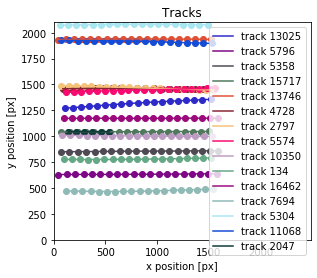

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (64, 40, 2)               0         
_________________________________________________________________
rnn-0 (LSTM)                 (64, 40, 1024)            4206592   
_________________________________________________________________
rnn-1 (LSTM)                 (64, 40, 16)              66624     
_________________________________________________________________
dense_1 (Dense)              (64, 40, 2)               34        
Total params: 4,273,250
Trainable params: 4,273,250
Non-trainable params: 0
_________________________________________________________________
None
0/1000: 	 loss=0.0013967572616892002
1/1000: 	 loss=0.0002747681211438549
2/1000: 	 loss=0.0001963283664698594
3/1000: 	 loss=9.920567633914804e-05
4/1000: 	 loss=3.278828943506206e-05
5/1000: 	 loss=0.00013649676389676643
6/1000: 	 loss

In [0]:
for name in ['Zylinder', 'Pfeffer', 'Kugeln', 'Weizen']:
  # download data
  url = 'pollithy.com/{}.zip'.format(name)
  zip_ = '{}.zip'.format(name)
  !wget -N {url}
  # unzip data
  !unzip -n {zip_}
  # train and evaluate model
  train_model(name)